# Predict Grant Applications

В этом ноутбуке решаем задачу **прогнозирования одобрения грантов** по данным конкурса UniMelb.

**Соревнование**: https://www.kaggle.com/competitions/unimelb/overview

Данные взяты из соревнования UniMelb на Kaggle, где требуется предсказать, будет ли заявка на грант **одобрена** (`Grant.Status = 1`) или **отклонена** (`Grant.Status = 0`).

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import torch
from sklearn.metrics import roc_auc_score, accuracy_score


In [102]:
train_data = pd.read_csv("../data/unimelb_training.csv")
test_data = pd.read_csv("../data/unimelb_test.csv")

/tmp/ipykernel_579513/3727527899.py:1: DtypeWarning: Columns (90,105,119,120,123,124,132,134,135,138,139,147,149,150,153,154,162,164,165,168,169,177,179,183,184,192,194,198,199,207,209,213,214,224,237,239,244) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("../data/unimelb_training.csv")


In [103]:
train_data.shape

(8708, 252)

In [104]:
train_data.head()

,Grant.Application.ID,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,Start.date,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,...,Faculty.No..15,With.PHD.15,No..of.Years.in.Uni.at.Time.of.Grant.15,Number.of.Successful.Grant.15,Number.of.Unsuccessful.Grant.15,A..15,A.15,B.15,C.15,Unnamed: 251
0,1,1,NaN,NaN,A,8/11/05,280199.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,2B,10A,B,11/11/05,280103.0,30.0,280106.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,29A,10B,A,14/11/05,321004.0,60.0,321216.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,40D,10B,C,15/11/05,270602.0,50.0,320602.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,59C,10A,A,16/11/05,260500.0,34.0,280000.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
train_data["Grant.Status"]

0       1
1       1
2       1
3       1
4       0
       ..
8703    1
8704    1
8705    0
8706    1
8707    1
Name: Grant.Status, Length: 8708, dtype: int64

## 1. Анализ целевой переменной (максимум 1 балл)

На этом шаге мы сосредотачиваемся на **целевой переменной** `Grant.Status`:
- считаем **количество** заявок в каждом классе (одобрено / отклонено);
- смотрим на **доли** классов, чтобы понять, насколько данные несбалансированы;
- визуализируем это с помощью **столбчатых диаграмм**

In [106]:
train_data["Grant.Status"].value_counts(normalize=False)

Grant.Status
0    4716
1    3992
Name: count, dtype: int64

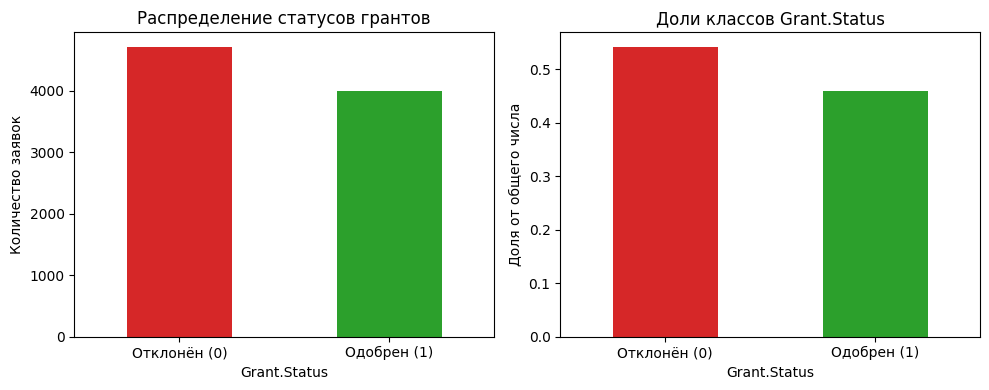

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

train_data["Grant.Status"].value_counts().sort_index().plot(
    kind="bar", ax=axes[0], color=["tab:red", "tab:green"]
)
axes[0].set_title("Распределение статусов грантов")
axes[0].set_xlabel("Grant.Status")
axes[0].set_ylabel("Количество заявок")
axes[0].set_xticklabels(["Отклонён (0)", "Одобрен (1)"], rotation=0)

train_data["Grant.Status"].value_counts(normalize=True).sort_index().plot(
    kind="bar", ax=axes[1], color=["tab:red", "tab:green"]
)
axes[1].set_title("Доли классов Grant.Status")
axes[1].set_xlabel("Grant.Status")
axes[1].set_ylabel("Доля от общего числа")
axes[1].set_xticklabels(["Отклонён (0)", "Одобрен (1)"], rotation=0)

plt.tight_layout()
plt.show()

/tmp/ipykernel_579513/3333146542.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data["Start.date_dt"] = pd.to_datetime(


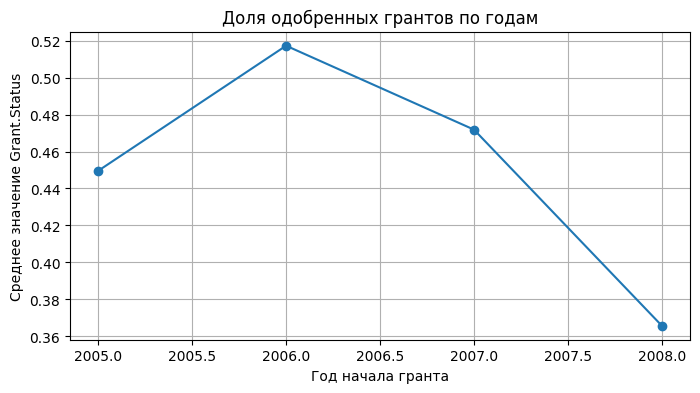

In [108]:
train_data["Start.date_dt"] = pd.to_datetime(
    train_data["Start.date"], dayfirst=True, errors="coerce"
)
grant_by_year = (
    train_data
    .dropna(subset=["Start.date_dt"])
    .assign(Year=lambda df: df["Start.date_dt"].dt.year)
    .groupby("Year")["Grant.Status"]
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(grant_by_year.index, grant_by_year.values, marker="o")
plt.title("Доля одобренных грантов по годам")
plt.xlabel("Год начала гранта")
plt.ylabel("Среднее значение Grant.Status")
plt.grid(True)
plt.show()


## 2. Анализ признаков (максимум 4 балла)

Переходим к **признакам**: смотрим их типы, распределения, наличие пропусков и возможные аномалии. Цель этого блока — понять, какие признаки можно использовать в моделях "как есть", какие требуют предварительной обработки, а какие, возможно, стоит удалить.

### [0.5] Типизация признаков (числовые, категориальные, временные) и их распределения

Сначала смотрим на типы данных в каждой колонке (`int`, `float`, `object`, `datetime` и т. д.).

Далее:
- удаляем столбцы, где все значения пропущены - такие признаки заведомо бесполезны для моделирования
- считаем, сколько колонок относится к каждому типу и визуализируем это

In [109]:
train_data.dtypes

Grant.Application.ID                         int64
Grant.Status                                 int64
Sponsor.Code                                object
Grant.Category.Code                         object
Contract.Value.Band...see.note.A            object
                                         ...      
A.15                                       float64
B.15                                       float64
C.15                                       float64
Unnamed: 251                               float64
Start.date_dt                       datetime64[ns]
Length: 253, dtype: object

In [110]:
train_data = train_data.dropna(axis=1, how="all")

In [111]:
train_data.shape

(8708, 231)

float64           158
object             70
int64               2
datetime64[ns]      1
Name: count, dtype: int64


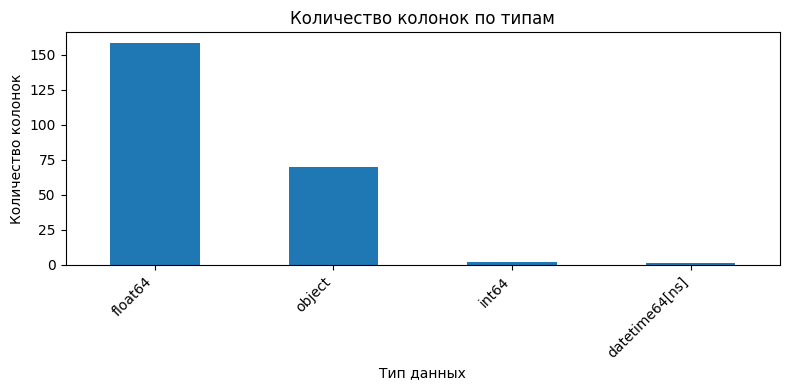

In [112]:
dtype_counts = train_data.dtypes.astype(str).value_counts().sort_values(ascending=False)
print(dtype_counts)

plt.figure(figsize=(8, 4))
dtype_counts.plot(kind="bar", color="tab:blue")
plt.title("Количество колонок по типам")
plt.xlabel("Тип данных")
plt.ylabel("Количество колонок")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### [0.5] Анализ пропущенных значений

Теперь разбираемся с пропущенными значениями:
- строим график количества `NaN` по колонкам (по оси X сами признаки скрыты, важен общий профиль)
- считаем доли пропусков и выводим топ-10 самых "пустых" колонок
- смотрим на перцентили долей пропусков, чтобы понять, для какого процента признаков пропусков особенно много

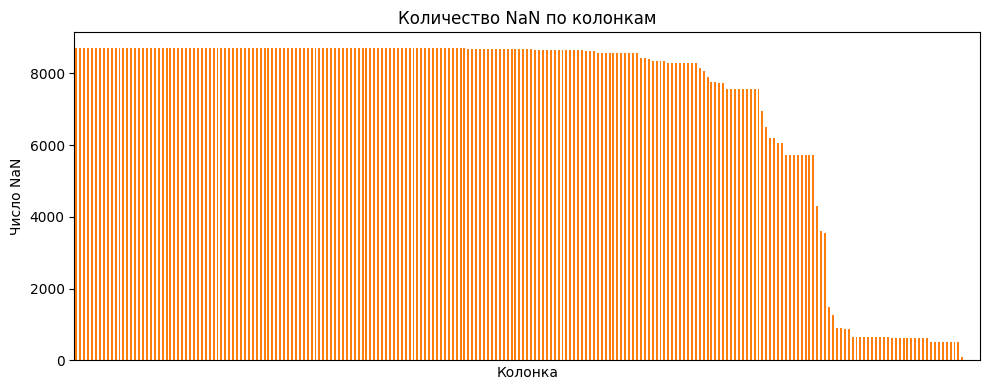

In [113]:
na_counts = train_data.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
na_counts.plot(kind="bar", color="tab:orange")
plt.title("Количество NaN по колонкам")
plt.xlabel("Колонка")
plt.ylabel("Число NaN")
plt.xticks([], [])
plt.tight_layout()
plt.show()


In [114]:
na_share = train_data.isna().mean().sort_values(ascending=False)
print("Доля пропусков по колонкам (top 10):")
print(na_share.head(10))

percentiles = na_share.quantile([0.0, 0.25, 0.5, 0.75, 0.9, 0.95, 1.0])
print("Перцентили долей пропусков по колонкам:")
print(percentiles)

Доля пропусков по колонкам (top 10):
Number.of.Successful.Grant.15              0.99977
Faculty.No..15                             0.99977
Year.of.Birth.15                           0.99977
Number.of.Unsuccessful.Grant.15            0.99977
Home.Language.9                            0.99977
Home.Language.7                            0.99977
Home.Language.8                            0.99977
No..of.Years.in.Uni.at.Time.of.Grant.15    0.99977
Person.ID.15                               0.99977
B.15                                       0.99977
dtype: float64
Перцентили долей пропусков по колонкам:
0.00    0.000000
0.25    0.869775
0.50    0.995866
0.75    0.999311
0.90    0.999655
0.95    0.999770
1.00    0.999770
dtype: float64


Удалим колонки, в которых больше **60% пропусков**.

Из предыдущей ячейки видно, что у значительной части признаков доля `NaN` очень велика (часто > 0.9). Такие колонки вряд ли дадут стабильный вклад в качество модели и могут приводить к переобучению или усложнению обработки.

Поэтому формируем список признаков, где доля пропусков > 0.6, удаляем их из датафрейма.

In [115]:
cols_to_drop = na_share[na_share > 0.60].index
print("Количество удаленных колонок:", len(cols_to_drop))

train_data = train_data.drop(columns=cols_to_drop)
train_data.shape

Количество удаленных колонок: 189


(8708, 42)

### [0.5] Выявление аномальных значений

Далее изучаем распределения числовых признаков чтобы найти возможные аномалии и сильные выбросы.

строим гистограммы для всех числовых колонок небольшими группами, чтобы визуально заметить "хвосты" и подозрительно большие значения

Удаляем технический идентификатор `Grant.Application.ID`, так как он не несёт содержательной информации о заявке, но может мешать моделям (особенно линейным)

In [116]:
train_data.columns

Index(['Grant.Application.ID', 'Grant.Status', 'Sponsor.Code',
       'Grant.Category.Code', 'Contract.Value.Band...see.note.A', 'Start.date',
       'RFCD.Code.1', 'RFCD.Percentage.1', 'RFCD.Code.2', 'RFCD.Percentage.2',
       'RFCD.Code.3', 'RFCD.Percentage.3', 'RFCD.Code.4', 'RFCD.Percentage.4',
       'RFCD.Code.5', 'RFCD.Percentage.5', 'SEO.Code.1', 'SEO.Percentage.1',
       'SEO.Code.2', 'SEO.Percentage.2', 'SEO.Code.3', 'SEO.Percentage.3',
       'SEO.Code.4', 'SEO.Percentage.4', 'SEO.Code.5', 'SEO.Percentage.5',
       'Person.ID.1', 'Role.1', 'Year.of.Birth.1', 'Country.of.Birth.1',
       'Dept.No..1', 'Faculty.No..1', 'With.PHD.1',
       'No..of.Years.in.Uni.at.Time.of.Grant.1',
       'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1',
       'A..1', 'A.1', 'B.1', 'C.1', 'Role.2', 'Start.date_dt'],
      dtype='object')

Числовых колонок: 32


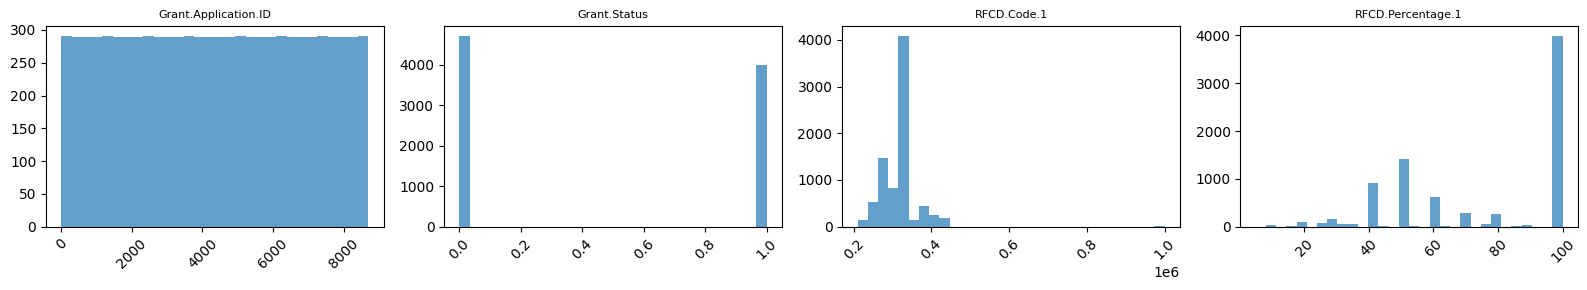

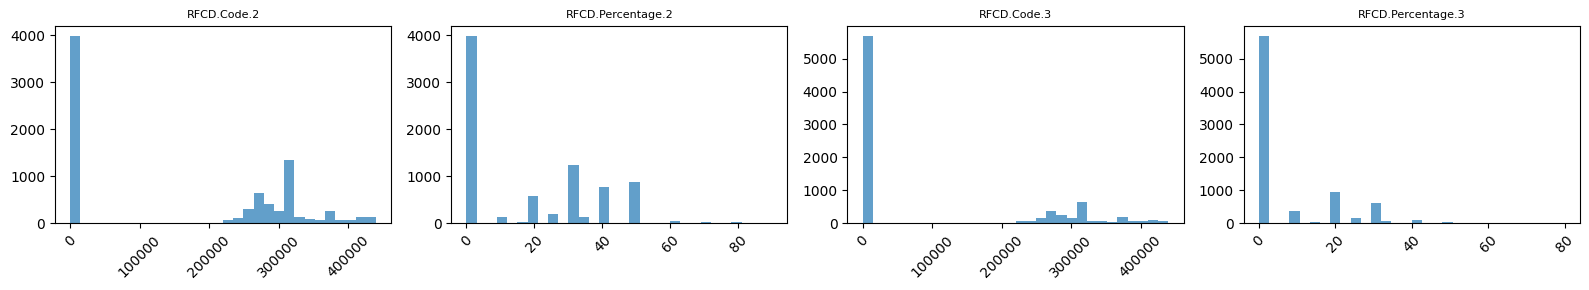

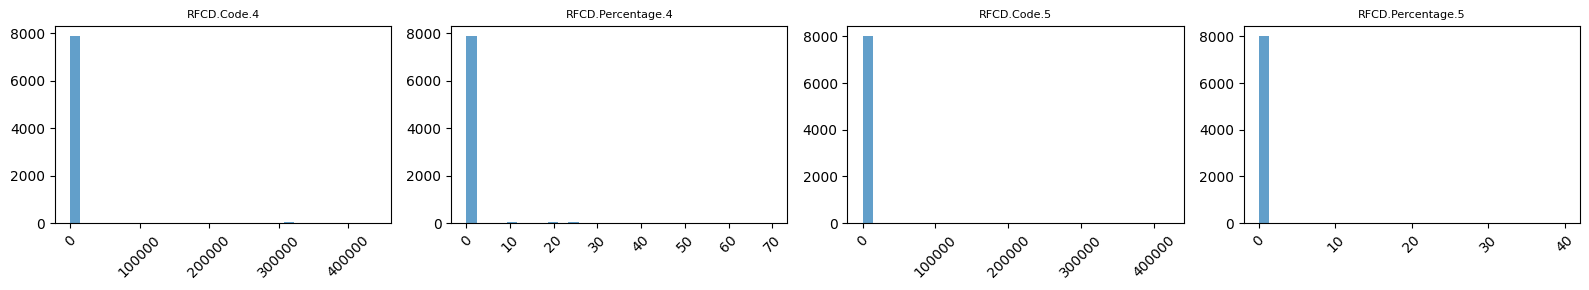

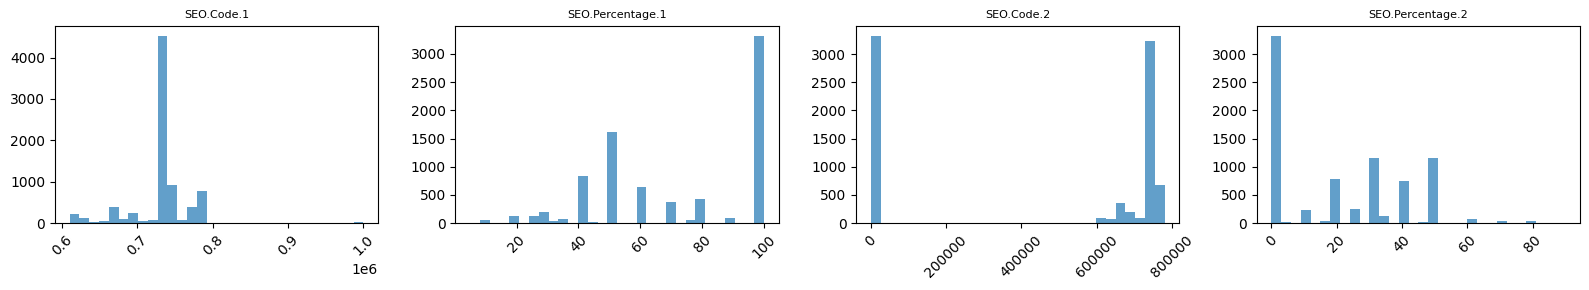

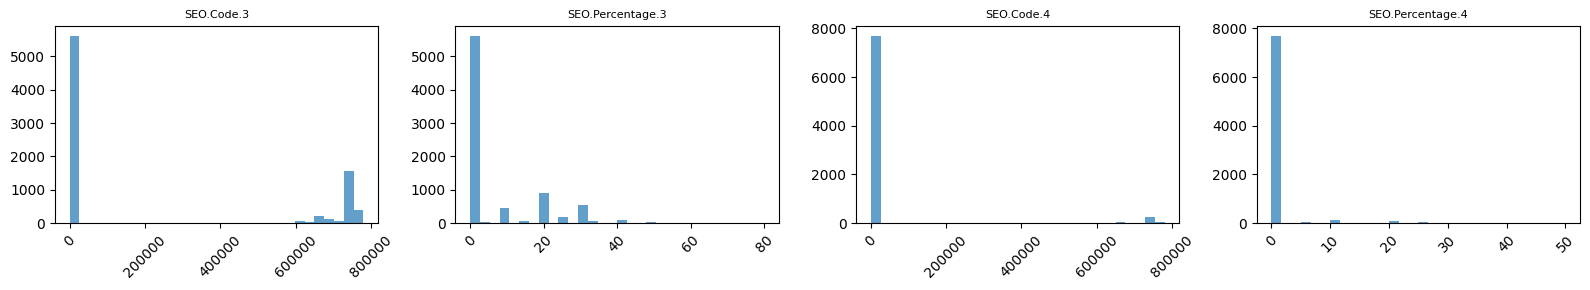

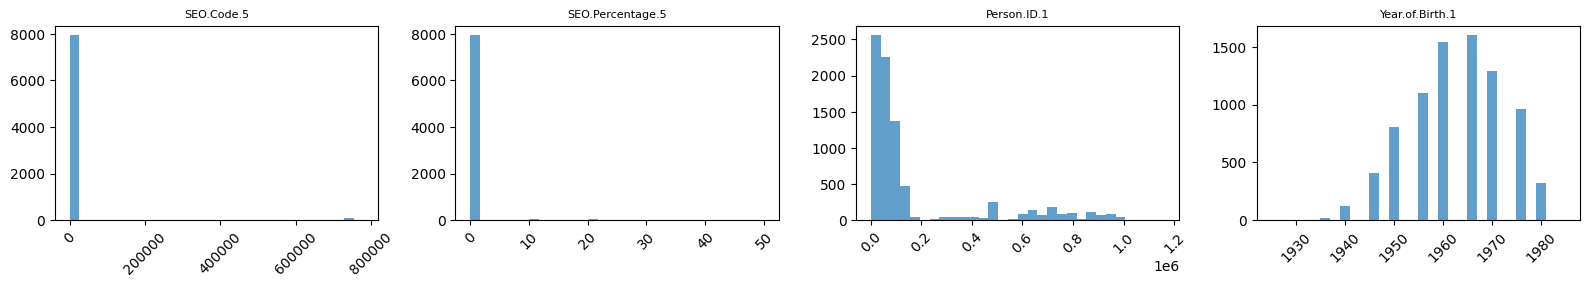

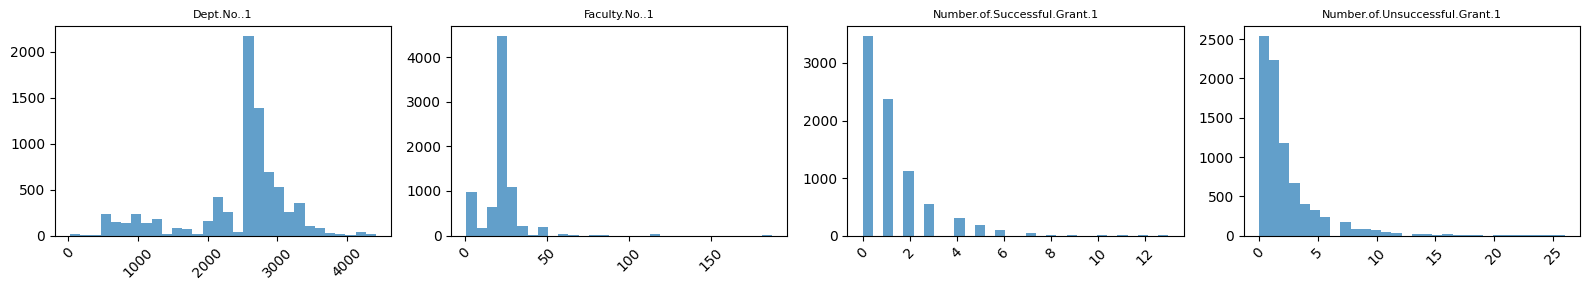

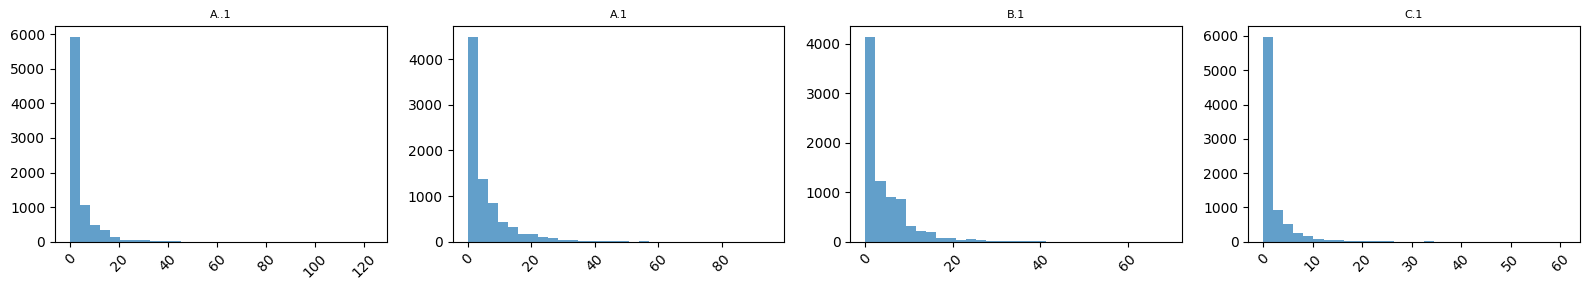

In [117]:
numeric_cols = train_data.select_dtypes(include=["number"]).columns
print(f"Числовых колонок: {len(numeric_cols)}")

cols_per_fig = 4

for i in range(0, len(numeric_cols), cols_per_fig):
    subset = numeric_cols[i : i + cols_per_fig]
    n_sub = len(subset)
    fig, axes = plt.subplots(1, n_sub, figsize=(4 * n_sub, 3))

    if n_sub == 1:
        axes = [axes]

    for ax, col in zip(axes, subset):
        ax.hist(train_data[col].dropna(), bins=30, color="tab:blue", alpha=0.7)
        ax.set_title(col, fontsize=8)
        ax.tick_params(axis="x", labelrotation=45)

    plt.tight_layout()
    plt.show()


<Axes: >

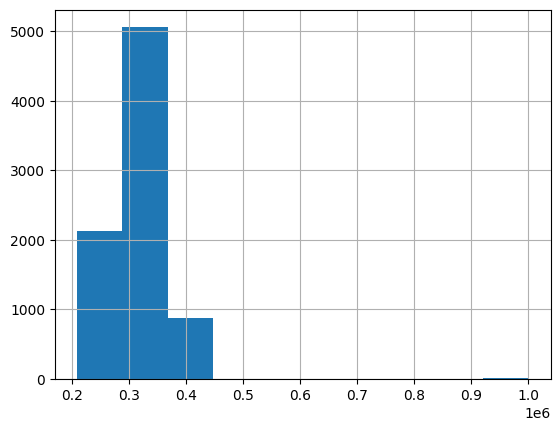

In [118]:
train_data["RFCD.Code.1"].hist()

In [119]:
train_data = train_data[train_data["RFCD.Code.1"] <= 0.9*1e6]
train_data.shape

(8057, 42)

In [120]:
train_data = train_data.drop(columns=['Grant.Application.ID'])

### [0.5] Анализ зависимостей между признаками

Посмотрим на взаимосвязи между числовыми признаками и возможные линейные/нелинейные зависимости:


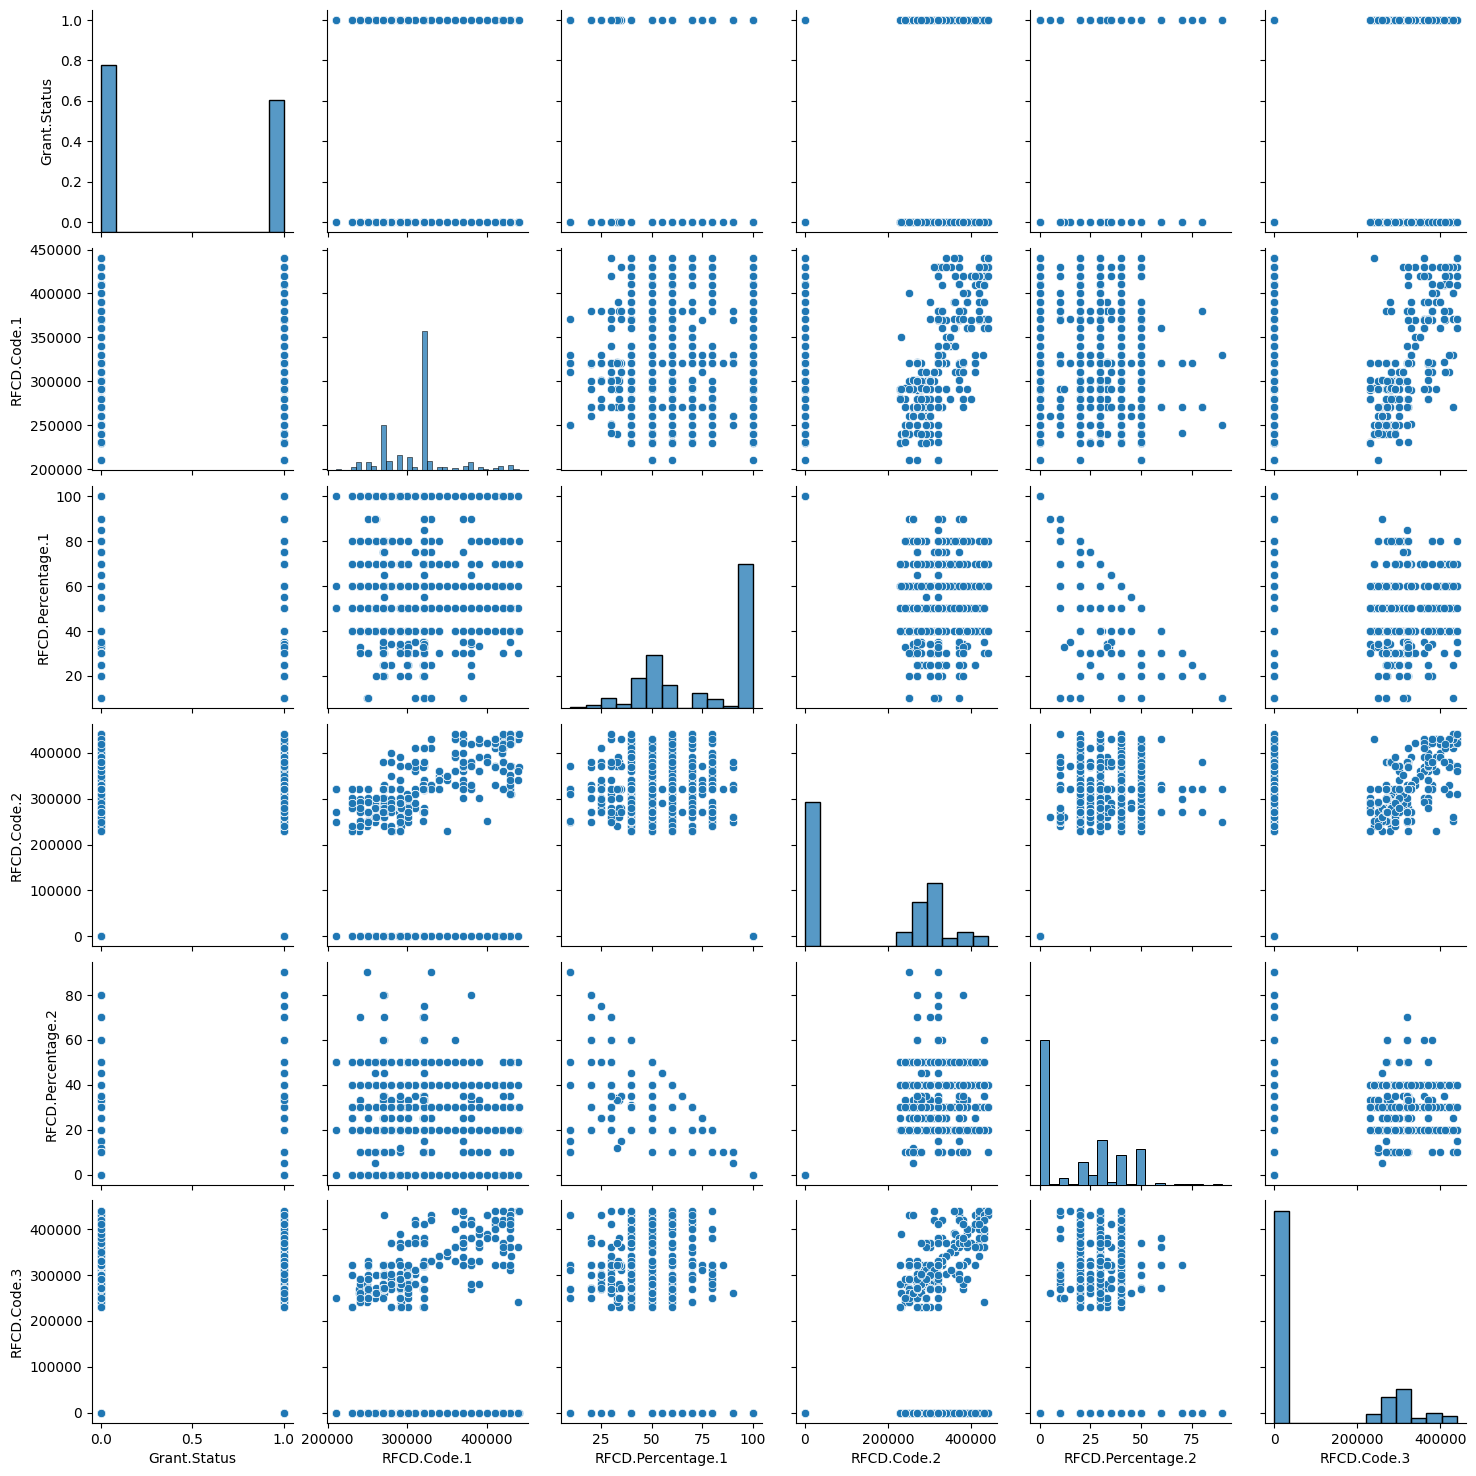

In [121]:
numeric_cols = train_data.select_dtypes(include=["number"]).columns
N = 6
subset_cols = numeric_cols[:N]

sample_size = 2000
if len(train_data) > sample_size:
    data_for_plot = train_data[subset_cols].sample(n=sample_size, random_state=42)
else:
    data_for_plot = train_data[subset_cols]

sns.pairplot(data_for_plot, diag_kind="hist")


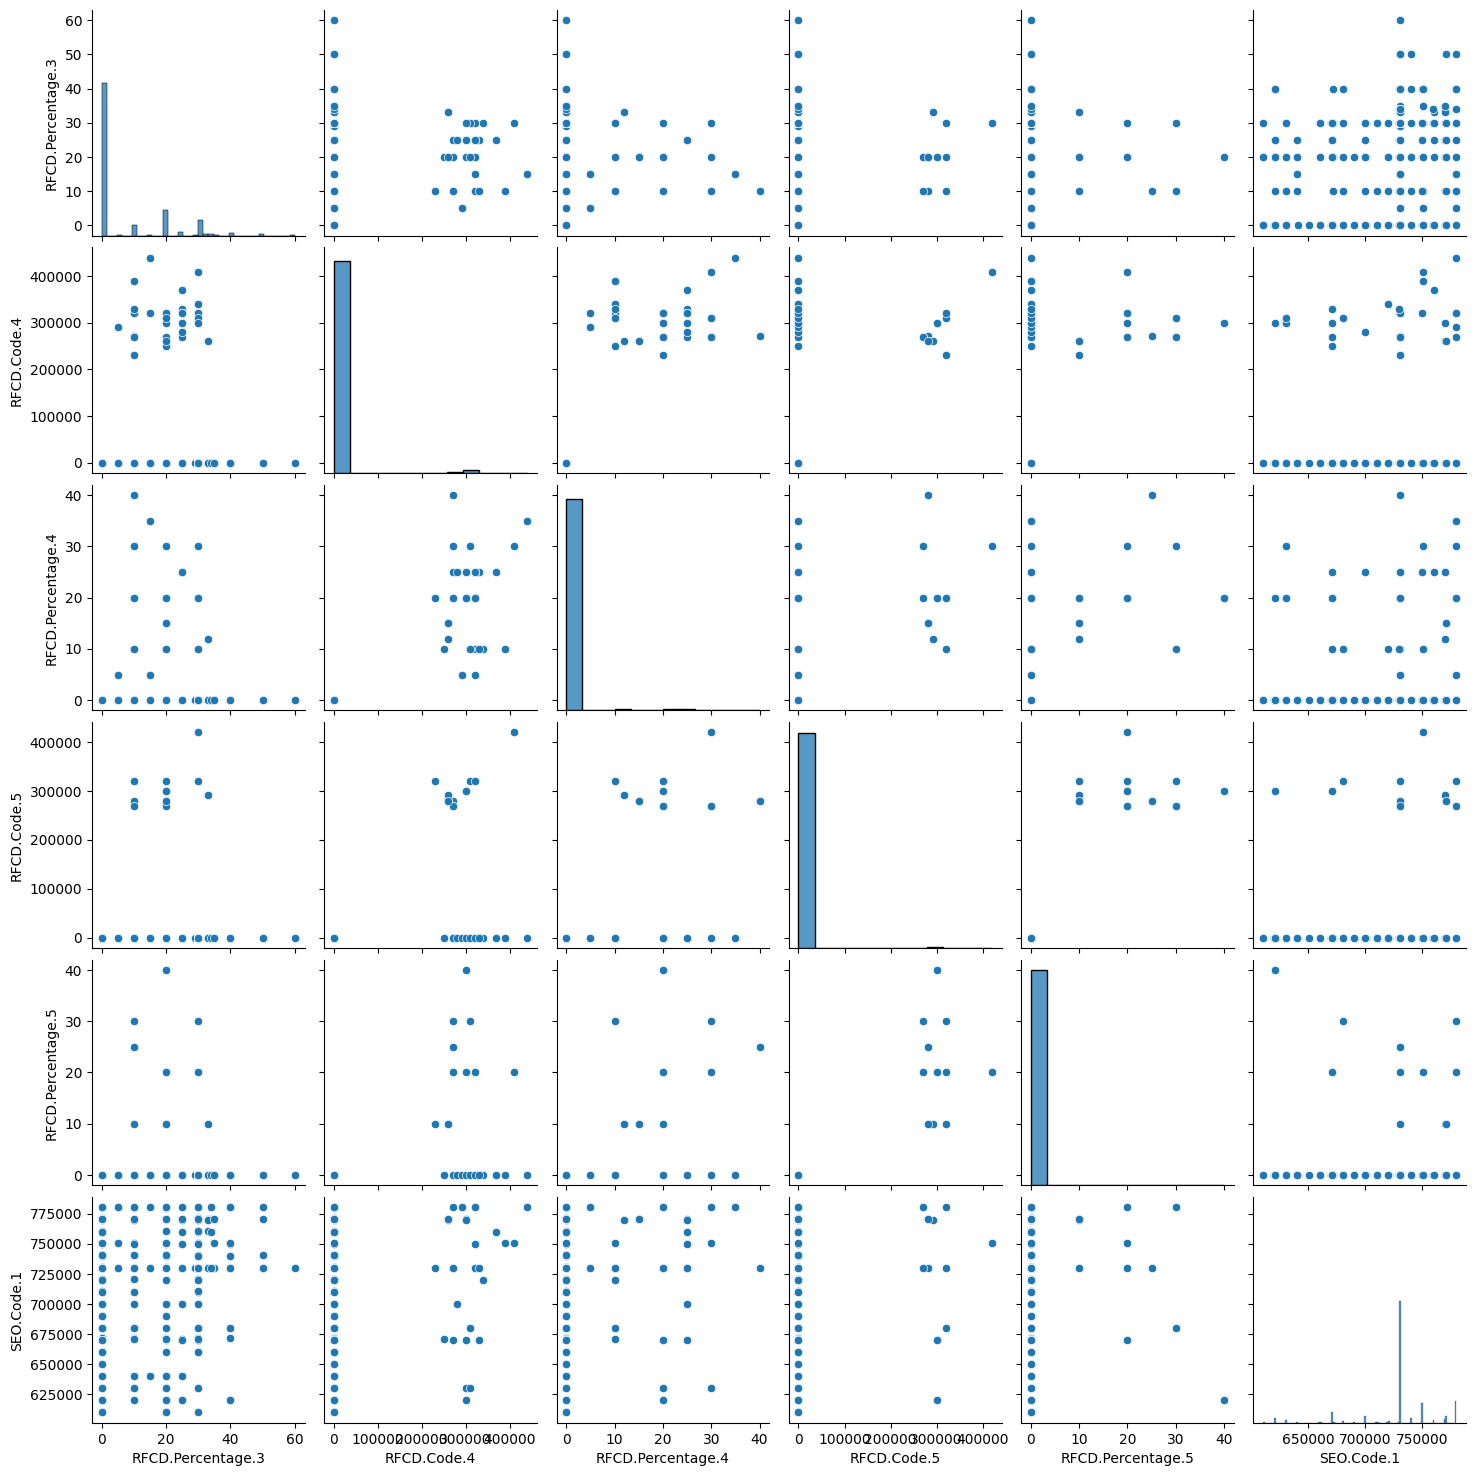

In [122]:
subset_cols = numeric_cols[N:2*N]
sample_size = 2000
if len(train_data) > sample_size:
    data_for_plot = train_data[subset_cols].sample(n=sample_size, random_state=42)
else:
    data_for_plot = train_data[subset_cols]

sns.pairplot(data_for_plot, diag_kind="hist")

### [0.5] Определение важности признаков (корреляции с таргетом)

Оценим влияние отдельных признаков на целевую переменную** `Grant.Status`

Функция `plot_feature_vs_target` строит:
- для числовых признаков - boxplot и violinplot по классам таргета, чтобы увидеть сдвиги распределений
- для категориальных признаков - два графика: среднее значение `Grant.Status` по категориям ("одобряемость" внутри группы) и количество наблюдений

In [123]:
def plot_feature_vs_target(df, feature, target="Grant.Status"):
    feature_series = df[feature]

    plt.figure(figsize=(10, 4))

    if pd.api.types.is_numeric_dtype(feature_series):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(data=df, x=target, y=feature, ax=axes[0])
        axes[0].set_title(f"Boxplot: {feature} vs {target}")

        sns.violinplot(data=df, x=target, y=feature, ax=axes[1])
        axes[1].set_title(f"Violinplot: {feature} vs {target}")

        for ax in axes:
            ax.set_xlabel(target)
            ax.set_ylabel(feature)

        plt.tight_layout()
        plt.show()

    else:
        stats = (
            df[[feature, target]]
            .dropna()
            .groupby(feature)[target]
            .agg(mean_target="mean", count="size")
            .sort_values("mean_target", ascending=False)
            .reset_index()
        )

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sns.barplot(data=stats, x=feature, y="mean_target", ax=axes[0])
        axes[0].set_title(f"Среднее значение {target} по категориям {feature}")
        axes[0].set_ylabel(f"Среднее {target}")
        axes[0].set_xlabel(feature)
        axes[0].tick_params(axis="x", rotation=45)
        axes[0].set_xticklabels(axes[0].get_xticklabels(), ha="right")

        sns.barplot(data=stats, x=feature, y="count", ax=axes[1])
        axes[1].set_title(f"Количество наблюдений по категориям {feature}")
        axes[1].set_ylabel("Количество")
        axes[1].set_xlabel(feature)
        axes[1].tick_params(axis="x", rotation=45)
        axes[1].set_xticklabels(axes[1].get_xticklabels(), ha="right")

        plt.tight_layout()
        plt.show()


In [124]:
train_data.columns

Index(['Grant.Status', 'Sponsor.Code', 'Grant.Category.Code',
       'Contract.Value.Band...see.note.A', 'Start.date', 'RFCD.Code.1',
       'RFCD.Percentage.1', 'RFCD.Code.2', 'RFCD.Percentage.2', 'RFCD.Code.3',
       'RFCD.Percentage.3', 'RFCD.Code.4', 'RFCD.Percentage.4', 'RFCD.Code.5',
       'RFCD.Percentage.5', 'SEO.Code.1', 'SEO.Percentage.1', 'SEO.Code.2',
       'SEO.Percentage.2', 'SEO.Code.3', 'SEO.Percentage.3', 'SEO.Code.4',
       'SEO.Percentage.4', 'SEO.Code.5', 'SEO.Percentage.5', 'Person.ID.1',
       'Role.1', 'Year.of.Birth.1', 'Country.of.Birth.1', 'Dept.No..1',
       'Faculty.No..1', 'With.PHD.1', 'No..of.Years.in.Uni.at.Time.of.Grant.1',
       'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1',
       'A..1', 'A.1', 'B.1', 'C.1', 'Role.2', 'Start.date_dt'],
      dtype='object')

/tmp/ipykernel_579513/3114106855.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha="right")
/tmp/ipykernel_579513/3114106855.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), ha="right")


<Figure size 1000x400 with 0 Axes>

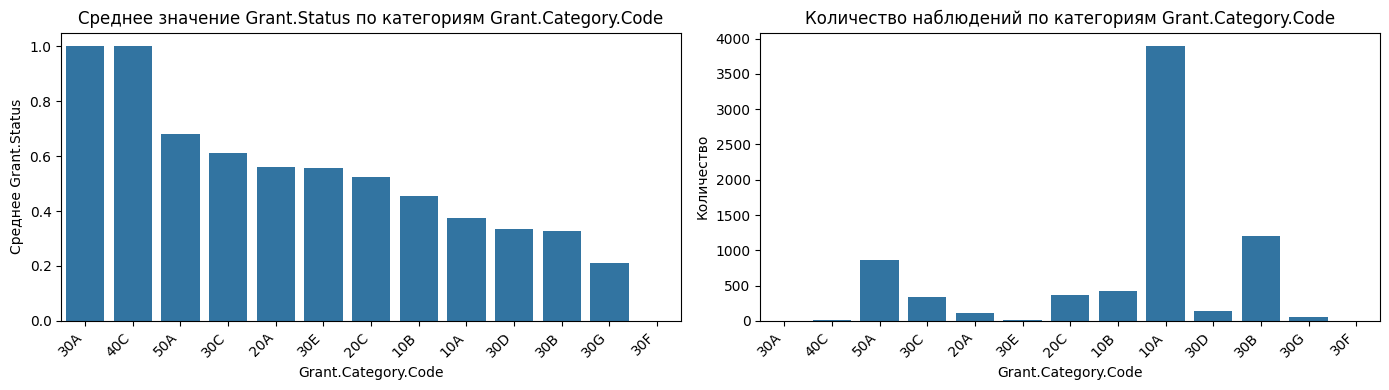

In [125]:
plot_feature_vs_target(train_data, "Grant.Category.Code")


<Figure size 1000x400 with 0 Axes>

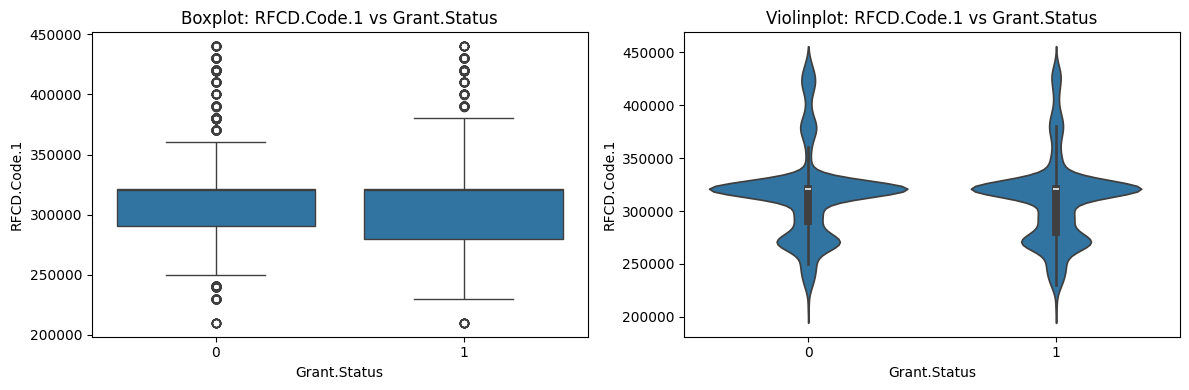

In [126]:
plot_feature_vs_target(train_data, "RFCD.Code.1")

<Figure size 1000x400 with 0 Axes>

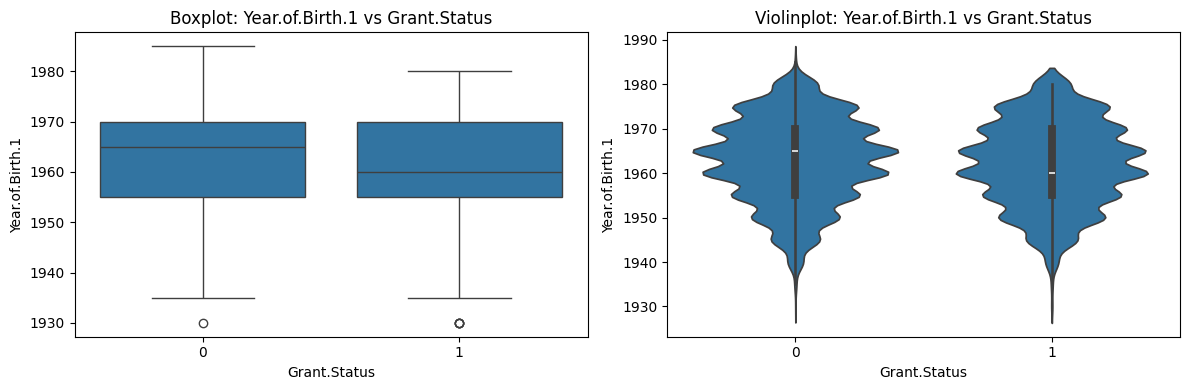

In [127]:
plot_feature_vs_target(train_data, "Year.of.Birth.1")


/tmp/ipykernel_579513/3114106855.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha="right")
/tmp/ipykernel_579513/3114106855.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), ha="right")


<Figure size 1000x400 with 0 Axes>

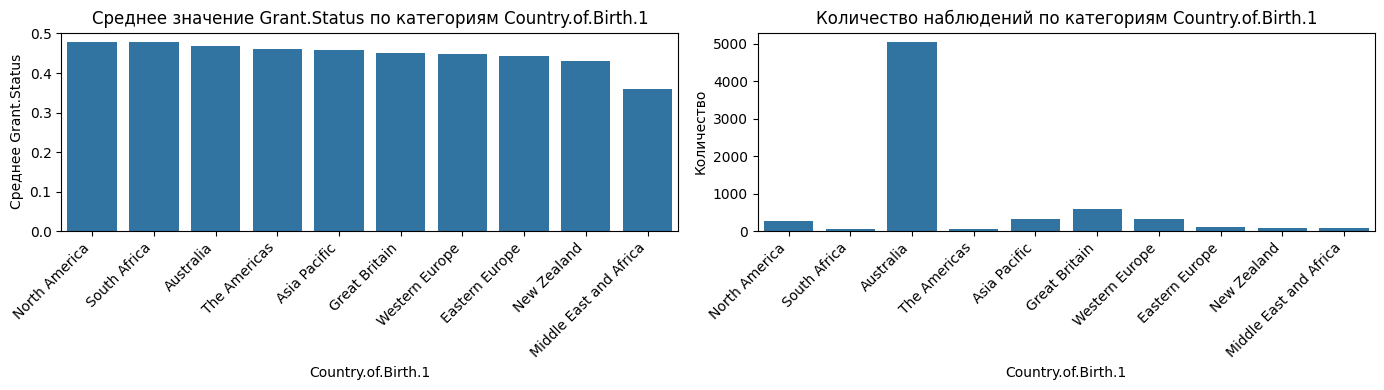

In [128]:
plot_feature_vs_target(train_data, "Country.of.Birth.1")


## Моделирование (максимум 3.5 балла)

### [0.25]  Обоснование стратегии разделения данных (train-test split)

Для оценки качества моделей мы делим обучающий датасет на **train** и **validation** с помощью `train_test_split`
- используем стратификацию по таргету чтобы сохранить исходное соотношение классов в обеих выборках
- выделяем 20% данных под валидацию.

In [129]:
train_data.columns

Index(['Grant.Status', 'Sponsor.Code', 'Grant.Category.Code',
       'Contract.Value.Band...see.note.A', 'Start.date', 'RFCD.Code.1',
       'RFCD.Percentage.1', 'RFCD.Code.2', 'RFCD.Percentage.2', 'RFCD.Code.3',
       'RFCD.Percentage.3', 'RFCD.Code.4', 'RFCD.Percentage.4', 'RFCD.Code.5',
       'RFCD.Percentage.5', 'SEO.Code.1', 'SEO.Percentage.1', 'SEO.Code.2',
       'SEO.Percentage.2', 'SEO.Code.3', 'SEO.Percentage.3', 'SEO.Code.4',
       'SEO.Percentage.4', 'SEO.Code.5', 'SEO.Percentage.5', 'Person.ID.1',
       'Role.1', 'Year.of.Birth.1', 'Country.of.Birth.1', 'Dept.No..1',
       'Faculty.No..1', 'With.PHD.1', 'No..of.Years.in.Uni.at.Time.of.Grant.1',
       'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1',
       'A..1', 'A.1', 'B.1', 'C.1', 'Role.2', 'Start.date_dt'],
      dtype='object')

In [135]:
target_col = "Grant.Status"

X = train_data.drop(columns=[target_col])
y = train_data[target_col]

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_valid.shape


((6445, 40), (1612, 40))

### [0.25] LAMA бейзлайн

#### Бейзлайн 1

In [151]:
target_col = "Grant.Status"
device = "cuda" if torch.cuda.is_available() else "cpu"

task = Task("binary", metric="auc")

automl_simple = TabularAutoML(
    task=task,
    timeout=1000,
    cpu_limit=8,
    reader_params={"n_jobs": 8, "cv": 3, "random_state": 42},
)

roles_simple = {
    "target": target_col,
}


In [152]:
train_df = X_train.copy()
train_df[target_col] = y_train

valid_df = X_valid.copy()
valid_df[target_col] = y_valid

oof_pred = automl_simple.fit_predict(train_df, roles=roles_simple, valid_data=valid_df, verbose=1)

[23:32:13] Stdout logging level is INFO.
[23:32:13] Task: binary

[23:32:13] Start automl preset with listed constraints:
[23:32:13] - time: 1000.00 seconds
[23:32:13] - CPU: 8 cores
[23:32:13] - memory: 16 GB

[23:32:13] Train data shape: (6445, 41)



/home/darinka/projects/Predict-Grant-Applications/.venv/lib/python3.10/site-packages/lightautoml/dataset/np_pd_dataset.py:590: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data[i] = pd.to_datetime(


[23:32:16] Layer 1 train process start. Time left 997.13 secs


/home/darinka/projects/Predict-Grant-Applications/.venv/lib/python3.10/site-packages/lightautoml/dataset/np_pd_dataset.py:590: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data[i] = pd.to_datetime(
/home/darinka/projects/Predict-Grant-Applications/.venv/lib/python3.10/site-packages/lightautoml/dataset/np_pd_dataset.py:590: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data[i] = pd.to_datetime(


[23:32:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:32:17] Time left 996.46 secs

[23:32:18] Selector_LightGBM fitting and predicting completed
[23:32:20] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:32:20] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs




































































































































































































































































































































Optimization Progress:  79%|███████▉  | 80/101 [05:01<01:19,  3.76s/it, best_trial=32, best_value=0.961]

[23:37:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[23:37:24] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[23:37:24] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
















































































































































































































































































































































































































Optimization Progress:  98%|█████████▊| 99/101 [05:03<00:06,  3.06s/it, best_trial=41, best_value=0.961]

[23:42:27] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[23:42:29] Time left 383.88 secs

[23:42:29] Layer 1 training completed.

[23:42:29] Blending: optimization starts with equal weights. Score = 0.9590886
[23:42:29] Blending: iteration 0: score = 0.9612014, weights = [0.         0.         0.59169006 0.07812058 0.33018935]
[23:42:29] Blending: iteration 1: score = 0.9613085, weights = [0.         0.         0.66264254 0.         0.33735743]
[23:42:29] Blending: no improvements for score. Terminated.

[23:42:29] Blending: best score = 0.9613085, best weights = [0.         0.         0.66264254 0.         0.33735743]
[23:42:29] Automl preset training completed in 616.24 seconds

[23:42:29] Model description:
Final prediction for new objects (level 0) = 
	 0.66264 * (1 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.33736 * (1 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



In [153]:
valid_pred = automl_simple.predict(valid_df)
valid_proba = valid_pred.data[:, 0]
valid_class = (valid_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_valid, valid_proba)
acc = accuracy_score(y_valid, valid_class)

print(f"ROC-AUC на валидации: {roc_auc:.4f}")
print(f"Accuracy на валидации: {acc:.4f}")

ROC-AUC на валидации: 0.9613
Accuracy на валидации: 0.8933


/home/darinka/projects/Predict-Grant-Applications/.venv/lib/python3.10/site-packages/lightautoml/dataset/np_pd_dataset.py:590: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data[i] = pd.to_datetime(


### Бейзлайн 2

In [156]:
roles_advanced = {
    "target": target_col,
    'drop': ['Start.date'],
    'datetime': ['Year.of.Birth.1', 'Start.date_dt'],
    'numeric': ['RFCD.Code.1', 'RFCD.Percentage.1', 'RFCD.Code.2', 'RFCD.Percentage.2', 'RFCD.Code.3',
       'RFCD.Percentage.3', 'RFCD.Code.4', 'RFCD.Percentage.4', 'RFCD.Code.5',
       'RFCD.Percentage.5', 'SEO.Code.1', 'SEO.Percentage.1', 'SEO.Code.2',
       'SEO.Percentage.2', 'SEO.Code.3', 'SEO.Percentage.3', 'SEO.Code.4',
       'SEO.Percentage.4', 'SEO.Code.5', 'SEO.Percentage.5', 'Person.ID.1'],
    'category': ['Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band...see.note.A'],
}


In [159]:
automl_advanced = TabularUtilizedAutoML(
    task=task,
    timeout=1000,
    cpu_limit=8,
    reader_params={
        'n_jobs': 8,
        'random_state': 42,
    },
    general_params={
        'use_algos': [['lgb_tuned', 'linear_l2']]
    },
    tuning_params={
        'fit_on_holdout': True,
    },
    selection_params={
        'select_algos': ['gbm', 'linear_l2'],
        'selection_feats_rate': 0.8,
        'max_features_cnt_in_result': None,
    }
)

train_df = X_train.copy()
train_df[target_col] = y_train

valid_df = X_valid.copy()
valid_df[target_col] = y_valid

oof_pred_advanced = automl_advanced.fit_predict(train_df, roles=roles_advanced, valid_data=valid_df, verbose=1)

[23:43:09] Start automl utilizator with listed constraints:
[23:43:09] - time: 1000.00 seconds
[23:43:09] - CPU: 8 cores
[23:43:09] - memory: 16 GB

[23:43:09] If one preset completes earlier, next preset configuration will be started

[23:43:09] ==================================================
[23:43:09] Start 0 automl preset configuration:
[23:43:09] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[23:43:09] Stdout logging level is INFO.
[23:43:09] Task: binary

[23:43:09] Start automl preset with listed constraints:
[23:43:09] - time: 1000.00 seconds
[23:43:09] - CPU: 8 cores
[23:43:09] - memory: 16 GB

[23:43:09] Train data shape: (6445, 41)



[23:43:12] Layer 1 train process start. Time left 997.29 secs
[23:43:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:43:13] Time left 996.55 secs

[23:43:13] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs
























































































































































































































































































































































































































Optimization Progress: 100%|██████████| 101/101 [04:14<00:00,  2.52s/it, best_trial=95, best_value=0.961]

[23:47:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed


[23:47:28] Time left 740.93 secs

[23:47:28] Layer 1 training completed.

[23:47:28] Blending: optimization starts with equal weights. Score = 0.9516401
[23:47:28] Blending: iteration 0: score = 0.9608490, weights = [0. 1.]
[23:47:28] Blending: no improvements for score. Terminated.

[23:47:28] Blending: best score = 0.9608490, best weights = [0. 1.]
[23:47:28] Automl preset training completed in 259.09 seconds

[23:47:28] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM) 

[23:47:28] ==================================================
[23:47:28] Start 1 automl preset configuration:
[23:47:28] conf_1_sel_type_1.yml, random state: {'reader_params': {'random_state': 43}, 'nn_params': {'random_state': 43}, 'general_params': {'return_all_predictions': False}}
[23:47:28] Stdout logging level is INFO.
[23:47:28] Task: binary

[23:47:28] Start automl preset with listed constraints:
[23:47:28] - time: 740.89 second























































































































































































































































































































































































































Optimization Progress: 100%|██████████| 101/101 [05:00<00:00,  2.98s/it, best_trial=91, best_value=0.958]

[23:52:31] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed


[23:52:31] Time left 437.84 secs

[23:52:32] Layer 1 training completed.

[23:52:32] Blending: optimization starts with equal weights. Score = 0.9489498
[23:52:32] Blending: iteration 0: score = 0.9571030, weights = [0. 1.]
[23:52:32] Blending: no improvements for score. Terminated.

[23:52:32] Blending: best score = 0.9571030, best weights = [0. 1.]
[23:52:32] Automl preset training completed in 303.07 seconds

[23:52:32] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM) 

[23:52:32] ==================================================
[23:52:32] Start 2 automl preset configuration:
[23:52:32] conf_2_select_mode_1_no_typ.yml, random state: {'reader_params': {'random_state': 44}, 'nn_params': {'random_state': 44}, 'general_params': {'return_all_predictions': False}}
[23:52:32] Stdout logging level is INFO.
[23:52:32] Task: binary

[23:52:32] Start automl preset with listed constraints:
[23:52:32] - time: 437























































































































































































































































































































































































































Optimization Progress: 100%|██████████| 101/101 [04:34<00:00,  2.72s/it, best_trial=62, best_value=0.959]

[23:57:08] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed


[23:57:08] Time left 160.97 secs

[23:57:08] Layer 1 training completed.

[23:57:08] Blending: optimization starts with equal weights. Score = 0.9465917
[23:57:08] Blending: iteration 0: score = 0.9565426, weights = [0. 1.]
[23:57:08] Blending: no improvements for score. Terminated.

[23:57:08] Blending: best score = 0.9565426, best weights = [0. 1.]
[23:57:08] Automl preset training completed in 276.84 seconds

[23:57:08] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM) 

[23:57:08] ==================================================
[23:57:08] Blending: optimization starts with equal weights. Score = 0.9613489
[23:57:08] Blending: iteration 0: score = 0.9620645, weights = [0.5902984  0.24168542 0.16801618]
[23:57:08] Blending: no improvements for score. Terminated.

[23:57:08] Blending: best score = 0.9620645, best weights = [0.5902984  0.24168542 0.16801618]


In [160]:
valid_pred = automl_advanced.predict(valid_df)
valid_proba = valid_pred.data[:, 0]
valid_class = (valid_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_valid, valid_proba)
acc = accuracy_score(y_valid, valid_class)

print(f"ROC-AUC на валидации: {roc_auc:.4f}")
print(f"Accuracy на валидации: {acc:.4f}")

Optimization Progress:  27%|██▋       | 27/101 [27:01<1:14:03, 60.05s/it, best_trial=6, best_value=0.96]

ROC-AUC на валидации: 0.9621
Accuracy на валидации: 0.8983


### [3.0] Собственное решение (если не удалось побить LLama baseline: 3 x 1.0 балл за различные пайплайны/попытки):

In [167]:
numeric_features = X_train.select_dtypes(include=["number"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


#### Логистическая регрессия

In [168]:
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1)),
])

log_reg_clf.fit(X_train, y_train)

y_proba_lr = log_reg_clf.predict_proba(X_valid)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

roc_auc_lr = roc_auc_score(y_valid, y_proba_lr)
acc_lr = accuracy_score(y_valid, y_pred_lr)

print(f"Logistic Regression — ROC-AUC на X_test: {roc_auc_lr:.4f}")
print(f"Logistic Regression — Accuracy на X_test: {acc_lr:.4f}")


Logistic Regression — ROC-AUC на X_test: 0.6218
Logistic Regression — Accuracy на X_test: 0.5744


/home/darinka/projects/Predict-Grant-Applications/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest

In [169]:
rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample",
    )),
])

rf_clf.fit(X_train, y_train)

y_proba_rf = rf_clf.predict_proba(X_valid)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

roc_auc_rf = roc_auc_score(y_valid, y_proba_rf)
acc_rf = accuracy_score(y_valid, y_pred_rf)

print(f"Random Forest — ROC-AUC на X_test: {roc_auc_rf:.4f}")
print(f"Random Forest — Accuracy на X_test: {acc_rf:.4f}")


Random Forest — ROC-AUC на X_test: 0.9410
Random Forest — Accuracy на X_test: 0.8672


#### k-Nearest Neighbours

In [170]:
knn_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", KNeighborsClassifier(
        n_neighbors=15,
        weights="distance",
        n_jobs=-1,
    )),
])

knn_clf.fit(X_train, y_train)

y_proba_knn = knn_clf.predict_proba(X_valid)[:, 1]
y_pred_knn = (y_proba_knn >= 0.5).astype(int)

roc_auc_knn = roc_auc_score(y_valid, y_proba_knn)
acc_knn = accuracy_score(y_valid, y_pred_knn)

print(f"kNN — ROC-AUC на X_test: {roc_auc_knn:.4f}")
print(f"kNN — Accuracy на X_test: {acc_knn:.4f}")


kNN — ROC-AUC на X_test: 0.6717
kNN — Accuracy на X_test: 0.6191


#### LightGBM

In [178]:
X_train_lgb = preprocessor.fit_transform(X_train, y_train)
X_valid_lgb = preprocessor.transform(X_valid)

lgbm_clf = LGBMClassifier(
    objective="binary",
    n_estimators=3000,
    learning_rate=0.02,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    min_child_samples=40,
    random_state=42,
    n_jobs=-1,
    device_type="gpu",
)

lgbm_clf.fit(
    X_train_lgb,
    y_train,
    eval_set=[(X_valid_lgb, y_valid)],
    eval_metric="auc"
)



,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.02
,n_estimators,3000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,40


In [ ]:
y_proba_lgb = lgbm_clf.predict_proba(X_valid_lgb)[:, 1]
y_pred_lgb = (y_proba_lgb >= 0.5).astype(int)

roc_auc_lgb = roc_auc_score(y_valid, y_proba_lgb)
acc_lgb = accuracy_score(y_valid, y_pred_lgb)

print(f"LightGBM — ROC-AUC на X_test: {roc_auc_lgb:.4f}")
print(f"LightGBM — Accuracy на X_test: {acc_lgb:.4f}")

LightGBM — ROC-AUC на X_test: 0.9355
LightGBM — Accuracy на X_test: 0.8573


/home/darinka/projects/Predict-Grant-Applications/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
